# Objectness Classification Models Analysis

In [81]:
import os
import sys
import git
import matplotlib.pyplot as plt
import torch

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

## Loading data

In [82]:
sys.path.append(f"{git_root}/objectness_classification/")
from seed import set_seed
sys.path.append(f"{git_root}/objectness_classification/datasets")
from datamodule import ObjnessClsDataModule

home = os.path.expanduser("~")
dataset_dir = os.path.join(home, "Documents/datasets")

set_seed()
iter_counter = 0

egohos_dataset = ObjnessClsDataModule(
    dataset_dir=dataset_dir,
    dataset_mode='egohos',
    batch_size=1,
    with_transform=False,
    with_info=True,
)
egohos_dataset.setup()

egohos_train_dataloader = iter(egohos_dataset.train_dataloader())

iter counter: 1
frames shape: torch.Size([1, 224, 224, 3])
file name: ('epic_P08_10_frame_0000007651',)


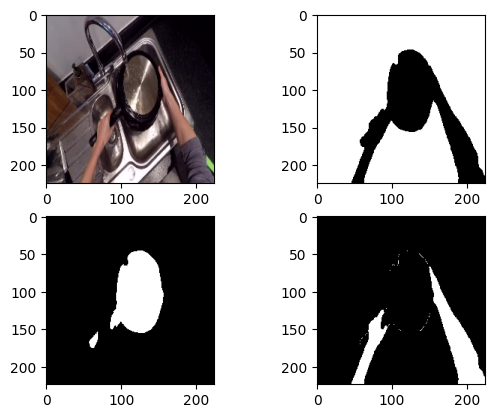

In [83]:
egohos_frames, egohos_labels, egohos_file = next(egohos_train_dataloader)
iter_counter += 1
print(
    f"iter counter: {iter_counter}",
    f"frames shape: {egohos_frames.shape}",
    f"file name: {egohos_file}",
    sep="\n",
)
egohos_img = egohos_frames[0]
egohos_mask = egohos_labels[0]

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(egohos_img)

fig.add_subplot(2, 2, 2)
plt.imshow(egohos_mask[0])
plt.gray()

fig.add_subplot(2, 2, 3)
plt.imshow(egohos_mask[1])
plt.gray()

fig.add_subplot(2, 2, 4)
plt.imshow(egohos_mask[2])
plt.gray()

plt.show()

plt.clf()
plt.close()

## Unet

torch.Size([1, 3, 224, 224])
model output shape: (1, 3, 224, 224)


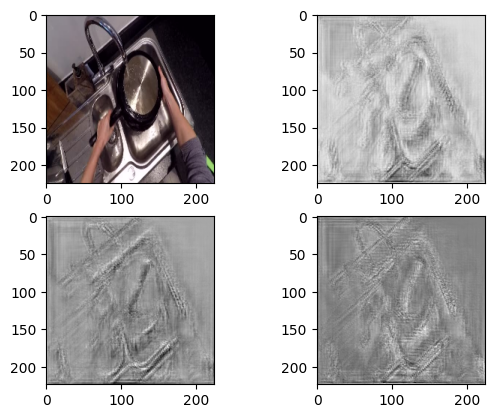

In [84]:
from unet import System

system = System()
model = system.model

print(model(torch.rand((1, 224, 224, 3))).shape)

model_path = os.path.join(git_root, "objectness_classification/logs/unet.ckpt")
model.load_state_dict(torch.load(model_path), strict=False)
model.eval()

output = model(egohos_frames.float())
output = output.detach().numpy()
print(
    f"model output shape: {output.shape}"
)
cls_num, _, _ = output[0].shape

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(egohos_frames[0])

for cls in range(cls_num):
    fig.add_subplot(2, 2, 2+cls)
    plt.imshow(output[0][cls])
    plt.gray()

plt.show()

plt.clf()
plt.close()

Argmax of output: 631
(224, 224, 3) (224, 224, 3)


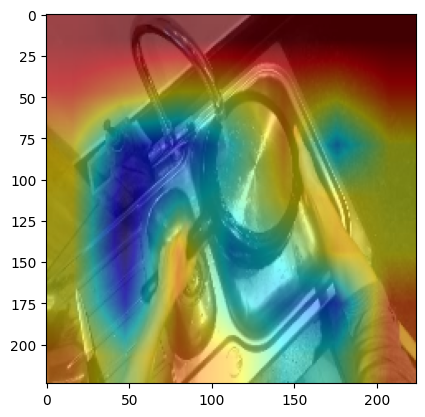

In [85]:
import numpy as np
import cv2
import torchvision.models as models
from torchcam.methods import GradCAM

model_path = os.path.join(git_root, "objectness_classification/logs/unet.ckpt")
param = torch.load(model_path)["state_dict"]
new_param = {}
for k in param.keys():
    if "model.unet.encoder" in k:
        new_param[k[19:]] = param[k]

model = models.resnet101(weights='DEFAULT')
model.load_state_dict(new_param, strict=False)
model.eval()

cam_extractor = GradCAM(model)

out = model(egohos_frames.float().permute(0,3,1,2))
class_idx = out.squeeze(0).argmax().item()
print(
    f"Argmax of output: {out.squeeze(0).argmax().item()}"
)
cams = cam_extractor(class_idx, out)
for i, cam in enumerate(cams):
    map = cam.squeeze(0).numpy()

    map_min = np.min(map)
    map_max = np.max(map)
    map = (map - map_min)/(map_max - map_min)

    map = cv2.resize(map, (224,224))
    map = (map*255).astype(np.uint8)

    heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
    print(heatmap.shape, egohos_frames[0].detach().numpy().shape)
    output = heatmap * 0.5 + egohos_frames[0].detach().numpy() * 0.5

fig = plt.figure()

fig.add_subplot(1, 1, 1)
plt.imshow(output.astype(np.uint8))

plt.show()

plt.clf()
plt.close()
